# Unsupervized Single-Cell Analysis in Triple Negative Breast Cancer

Due to tumour heterogeneity (https://en.wikipedia.org/wiki/Tumour_heterogeneity), we expect different cancer cells to react differently to a specific drug. Therefore, we expect a particular drug to affect the gene expressions of only a subpopulation of the cancer cells. Moreover, gene expression is quantitative and its level is different for different cells. Hence, we require multiple cells to identify the genes with statistically significant altered expression.

LOADING THE DATA:

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import scipy as sp
import sklearn as sk

In [2]:
BayesInferenceBase = pd.read_csv("BayesInferenceBase.csv")
BayesInferenceBase.head()

,CellName,time,temp
0,BaselineCell_1,short,cool
1,BaselineCell_2,short,cool
2,BaselineCell_3,short,warm
3,BaselineCell_4,short,hot
4,BaselineCell_5,short,hot


In [3]:
BayesInferenceMetf = pd.read_csv("BayesInferenceMetf.csv")
BayesInferenceMetf.head()

,CellName,time,temp
0,Metformin_1,short,cool
1,Metformin_2,short,cold
2,Metformin_3,short,warm
3,Metformin_4,short,cool
4,Metformin_5,short,cold


In [4]:
GeneExpression_Baseline = pd.read_csv("GeneExpression_Baseline.csv")
GeneExpression_Baseline.head()

,GeneID,Chr,Start,Stop,CodingLength,BaselineCell_1,BaselineCell_2,BaselineCell_3,BaselineCell_4,BaselineCell_5,...,BaselineCell_183,BaselineCell_184,BaselineCell_185,BaselineCell_186,BaselineCell_187,BaselineCell_188,BaselineCell_189,BaselineCell_190,BaselineCell_191,BaselineCell_192
0,DDX11L1,chr1,11874,14408,1651,61,47,72,77,75,...,39,34,28,25,30,29,92,26,43,33
1,WASH7P,chr1,14362,29370,1769,72,60,79,80,81,...,26,26,19,26,19,22,96,33,32,44
2,FAM138A,chr1,34611,36081,1130,159,182,152,133,147,...,59,64,44,51,47,54,145,57,65,59
3,FAM138F,chr1,34611,36081,1130,64,54,88,92,63,...,24,31,23,19,25,33,86,45,25,20
4,OR4F5,chr1,69091,70008,918,61,57,63,61,69,...,40,41,17,25,27,27,99,31,32,29


In [5]:
GeneExpression_Metformin = pd.read_csv("GeneExpression_Metformin.csv")
GeneExpression_Metformin.head()

,GeneID,Chr,Start,Stop,CodingLength,MetforminCell_1,MetforminCell_2,MetforminCell_3,MetforminCell_4,MetforminCell_5,...,MetforminCell_183,MetforminCell_184,MetforminCell_185,MetforminCell_186,MetforminCell_187,MetforminCell_188,MetforminCell_189,MetforminCell_190,MetforminCell_191,MetforminCell_192
0,DDX11L1,chr1,11874,14408,1651,40,75,37,107,100,...,83,111,14,31,102,67,38,93,35,45
1,WASH7P,chr1,14362,29370,1769,84,75,57,74,71,...,67,83,19,31,112,70,32,76,39,38
2,FAM138A,chr1,34611,36081,1130,142,108,74,168,148,...,107,111,24,76,176,131,74,153,59,93
3,FAM138F,chr1,34611,36081,1130,75,61,45,97,54,...,61,104,17,26,86,81,37,86,39,38
4,OR4F5,chr1,69091,70008,918,84,86,39,94,74,...,55,61,29,23,57,87,45,96,59,48


In [6]:
QualityControl = pd.read_csv("QualityControl.csv")
QualityControl.head()

,temp,time,viab,qual
0,cool,short,high,good
1,hot,short,low,good
2,warm,short,high,good
3,cool,short,high,bad
4,cool,short,high,good


**Number of cells that were sequenced:**

In [7]:
GeneExpression_Baseline.shape[1] - 5 #As there are 5 initial gene-specific fields

192

**Number of genes that were sequenced:**

In [8]:
GeneExpression_Baseline["GeneID"].nunique()

23346

**Distribution of genes across chromosomes:**

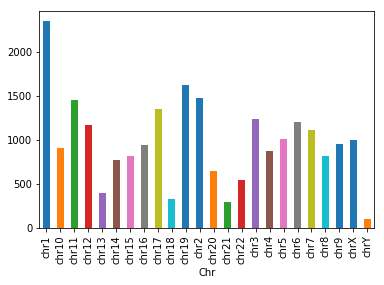

In [9]:
z=GeneExpression_Metformin.groupby("Chr")["GeneID"].nunique()
z.plot.bar()
plt.xticks(rotation='vertical')
plt.rcParams["figure.figsize"] = 12, 8
plt.show()

We see that the genes are not equally distributed across chromosomes.

**Distribution of coding length:**

/Users/nihithindlekar/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


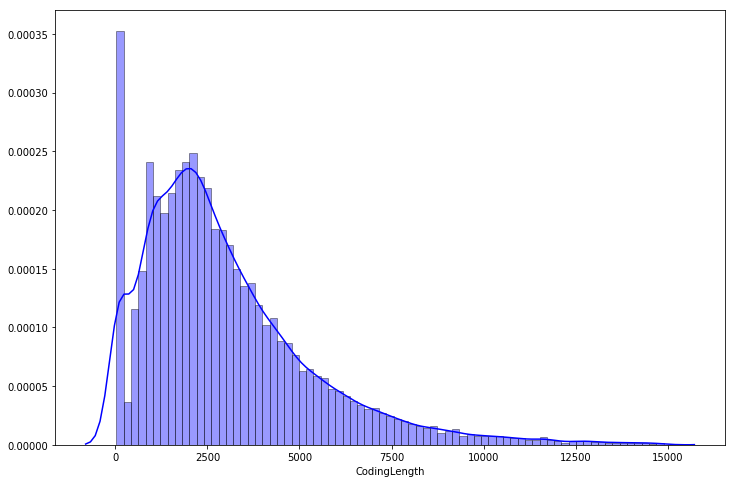

In [10]:
coding_length = GeneExpression_Metformin[GeneExpression_Metformin.CodingLength < 15000]
sns.distplot(coding_length["CodingLength"], hist=True, kde=True, 
             bins=75, color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.rcParams["figure.figsize"] = 8, 12

**Data Cleaning and Visual Inspection**

**Bayesian Network for Quality Control**

Not all cells used in the experiment yield high-quality data. Identifying and removing potentially problematic cells is critical for downstream analysis. In scRNA-seq, factors such as machine failures, batch effects might impact the quality of the data. For the purpose of this project, we will limit the factors to the ones described below.

If one observes that data quality is related to temperature, time, etc., one can identify the poor quality cells using a Bayesian approach. Consider the following Bayesian Network for quality control:

![alt text](BN.png "Bayesian Network")

**Joint probability distribution:**

P(Q, V, Te, Ti) = P(Q | V, Ti)* P(V | Te, Ti)* P(Te)* P(Ti)

**Parameters needed to define the conditional probability distribution
of the Bayesian Network for quality control:**

31

**Conditional probability tables P(Quality|Viability, Time), P(Viability|Temperature, Time), P(Temperature), P(Time) for the above network. Training data is from ​QualityControl.csv​:**

In [11]:
CPT_Q_V_Ti_header = {'V':[], 'Ti':[], 'Q_Good':[], 'Q_Bad':[]}
CPT_Q_V_Ti = pd.DataFrame(CPT_Q_V_Ti_header)
CPT_V_Te_Ti_header = {'Te':[], 'Ti':[], 'V_High':[], 'V_Low':[]}
CPT_V_Te_Ti = pd.DataFrame(CPT_V_Te_Ti_header)
CPT_Te_header = {'cold':[], 'cool':[], 'warm':[], 'hot':[]}
CPT_Te = pd.DataFrame(CPT_Te_header)
CPT_Ti_header = {'short':[], 'long':[]}
CPT_Ti = pd.DataFrame(CPT_Ti_header)

In [12]:
distinct_Ti = QualityControl["time"].unique()
distinct_Te = QualityControl["temp"].unique()
distinct_V = QualityControl["viab"].unique()

In [13]:
distinct_V_Ti = np.transpose([np.tile(distinct_V, len(distinct_Ti)), np.repeat(distinct_Ti, len(distinct_V))])
distinct_V_Ti

array([['high', 'short'],
       ['low', 'short'],
       ['high', 'long'],
       ['low', 'long']], dtype=object)

In [14]:
location = 0
for each in distinct_V_Ti:
    count_total = 0
    count_good = 0
    for each_q in QualityControl.iterrows():
        if each_q[1][1] == each[1] and each_q[1][2] == each[0]:
            count_total += 1
        if each_q[1][1] == each[1] and each_q[1][2] == each[0] and each_q[1][3] == 'good':
            count_good += 1
    good_prob = count_good / float(count_total)
    bad_prob = 1 - good_prob
    CPT_Q_V_Ti.loc[location] = [each[0], each[1], good_prob, bad_prob]
    location += 1

In [15]:
CPT_Q_V_Ti

,V,Ti,Q_Good,Q_Bad
0,high,short,0.894852,0.105148
1,low,short,0.517321,0.482679
2,high,long,0.522293,0.477707
3,low,long,0.047619,0.952381


In [16]:
distinct_Te_Ti = np.transpose([np.tile(distinct_Te, len(distinct_Ti)), np.repeat(distinct_Ti, len(distinct_Te))])
distinct_Te_Ti

array([['cool', 'short'],
       ['hot', 'short'],
       ['warm', 'short'],
       ['cold', 'short'],
       ['cool', 'long'],
       ['hot', 'long'],
       ['warm', 'long'],
       ['cold', 'long']], dtype=object)

In [17]:
location = 0
for each in distinct_Te_Ti:
    count_total = 0
    count_good = 0
    for each_q in QualityControl.iterrows():
        if each_q[1][1] == each[1] and each_q[1][0] == each[0]:
            count_total += 1
        if each_q[1][1] == each[1] and each_q[1][0] == each[0] and each_q[1][2] == 'high':
            count_good += 1
    high_prob = count_good / float(count_total)
    low_prob = 1 - high_prob
    CPT_V_Te_Ti.loc[location] = [each[0], each[1], high_prob, low_prob]
    location += 1

In [18]:
CPT_V_Te_Ti

,Te,Ti,V_High,V_Low
0,cool,short,0.948268,0.051732
1,hot,short,0.212815,0.787185
2,warm,short,0.906657,0.093343
3,cold,short,0.415966,0.584034
4,cool,long,0.792829,0.207171
5,hot,long,0.071429,0.928571
6,warm,long,0.707143,0.292857
7,cold,long,0.265306,0.734694


In [19]:
QualityControl.head()

,temp,time,viab,qual
0,cool,short,high,good
1,hot,short,low,good
2,warm,short,high,good
3,cool,short,high,bad
4,cool,short,high,good


In [20]:
#CPT_Te_header = {'cold':[], 'cool':[], 'warm':[], 'hot':[]}
count_cold = 0
count_cool = 0
count_warm = 0
count_hot = 0
total = 0
for each_q in QualityControl.iterrows():
    if each_q[1][0] == 'cold':
        count_cold += 1
    if each_q[1][0] == 'cool':
        count_cool += 1
    if each_q[1][0] == 'warm':
        count_warm += 1
    if each_q[1][0] == 'hot':
        count_hot += 1
    total += 1
CPT_Te.loc[0] = [count_cold/float(total), count_cool/float(total), count_warm/float(total), count_hot/float(total)]
CPT_Te

,cold,cool,warm,hot
0,0.105,0.4948,0.3044,0.0958


In [21]:
#CPT_Ti_header = {'short':[], 'long':[]}
count_short = 0
count_long = 0
total = 0
for each_q in QualityControl.iterrows():
    if each_q[1][1] == 'short':
        count_short += 1
    if each_q[1][1] == 'long':
        count_long += 1
    total += 1
CPT_Ti.loc[0] = [count_short/float(total), count_long/float(total)]
CPT_Ti

,short,long
0,0.9036,0.0964


**P(Quality|Temperature, Time) for all possible values of Quality, Temperature and Time:**

P(Q|Te,Ti) = [P(Q|V=low,Te,Ti)* P(V=low|Te,Ti) + P(Q|V=high,Te,Ti)* P(V=high|Ti,Te)]* P(Te)* P(Ti)

In [22]:
Q_Te_Ti_header = {'Te':[], 'Ti':[], 'Q_good':[], 'Q_bad':[]}
Q_Te_Ti = pd.DataFrame(Q_Te_Ti_header)
location = 0
for each in distinct_Te_Ti:
    goodlow = 0
    goodhigh = 0
    totallow = 0
    totalhigh = 0
    for each_q in QualityControl.iterrows():
        if each_q[1][0] == each[0] and each_q[1][1] == each[1] and each_q[1][2] == 'low' and each_q[1][3] == 'good':
            goodlow += 1
        if each_q[1][0] == each[0] and each_q[1][1] == each[1] and each_q[1][2] == 'high' and each_q[1][3] == 'good':
            goodhigh += 1
        if each_q[1][0] == each[0] and each_q[1][1] == each[1] and each_q[1][2] == 'low':
            totallow += 1
        if each_q[1][0] == each[0] and each_q[1][1] == each[1] and each_q[1][2] == 'high':
            totalhigh += 1
    VH_Ti_Te_row = CPT_V_Te_Ti[(CPT_V_Te_Ti["Te"] == each[0]) & (CPT_V_Te_Ti["Ti"] == each[1])]
    VH_Ti_Te = VH_Ti_Te_row["V_High"]
    VL_Ti_Te_row = CPT_V_Te_Ti[(CPT_V_Te_Ti["Te"] == each[0]) & (CPT_V_Te_Ti["Ti"] == each[1])]
    VL_Ti_Te = VL_Ti_Te_row["V_Low"]
    QGood = ((goodlow/float(totallow))*float(VL_Ti_Te) + (goodhigh/float(totalhigh))*float(VH_Ti_Te))*CPT_Ti[each[1]][0]*CPT_Te[each[0]][0]
    QBad = (((totallow - goodlow)/float(totallow))*float(VL_Ti_Te) + ((totalhigh - goodhigh)/float(totalhigh))*float(VH_Ti_Te))*CPT_Ti[each[1]][0]*CPT_Te[each[0]][0]
    Q_Te_Ti.loc[location] = [each[0], each[1], QGood, QBad]
    location += 1

In [23]:
Q_Te_Ti

,Te,Ti,Q_good,Q_bad
0,cool,short,0.390786,0.056315
1,hot,short,0.052295,0.034269
2,warm,short,0.237241,0.037815
3,cold,short,0.063186,0.031692
4,cool,long,0.020334,0.027365
5,hot,long,0.000880,0.008356
6,warm,long,0.011109,0.018235
7,cold,long,0.001653,0.008469


**Clearly all cells with 'long' time are of 'bad' quality.**

**So, we drop all cells which were treated for a long time:**

In [24]:
Base_fin = BayesInferenceBase[BayesInferenceBase["time"] == "long"]
Metf_fin = BayesInferenceMetf[BayesInferenceMetf["time"] == "long"]
bad_base = list(Base_fin["CellName"].values)
bad_met = list(Metf_fin["CellName"].values)
bad_met

['Metformin_185',
 'Metformin_186',
 'Metformin_187',
 'Metformin_188',
 'Metformin_189',
 'Metformin_190',
 'Metformin_191',
 'Metformin_192']

In [25]:
bad_met = [item.replace('Metformin','MetforminCell') for item in bad_met]
bad_met

['MetforminCell_185',
 'MetforminCell_186',
 'MetforminCell_187',
 'MetforminCell_188',
 'MetforminCell_189',
 'MetforminCell_190',
 'MetforminCell_191',
 'MetforminCell_192']

In [26]:
GeneExpression_Baseline = GeneExpression_Baseline.drop(bad_base, axis = 1)                                                  
GeneExpression_Metformin = GeneExpression_Metformin.drop(bad_met, axis = 1)

**Data Standardization**

A well-known bias in scRNA-seq experiments is the amount of reagent consumed. For each cell, the expression level from all genes are scaled by the same constant corresponding to the amount of reagent consumed for that cell. The constant varies across cells. Therefore, to compare the expression level across cells, we normalize the data.

**We calculate the sum of expression level (summing up all genes) of each cell. Plot the histogram of the sums.**

In [27]:
GeneExpression_Baseline_normalized = GeneExpression_Baseline
GeneExpression_Metformin_normalized = GeneExpression_Metformin

In [28]:
sums_base = GeneExpression_Baseline_normalized.select_dtypes(pd.np.number).sum()

In [29]:
sums_met = GeneExpression_Metformin_normalized.select_dtypes(pd.np.number).sum()

In [30]:
i = 0
while i < 184:
    GeneExpression_Baseline_normalized["BaselineCell_" + str(i+1)] = GeneExpression_Baseline_normalized["BaselineCell_" + str(i+1)].div(sums_base[3+i])
    i += 1

In [31]:
i = 0
while i < 184:
    GeneExpression_Metformin_normalized["MetforminCell_" + str(i+1)] = GeneExpression_Metformin_normalized["MetforminCell_" + str(i+1)].div(sums_met[3+i])
    i += 1

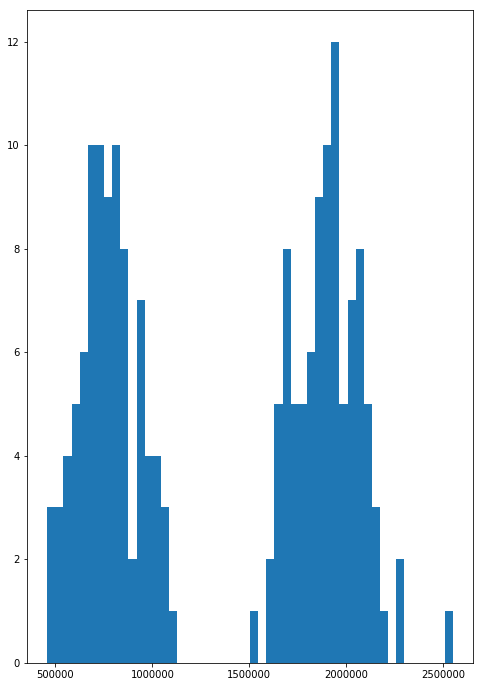

In [32]:
plt.hist(sums_base[3:], bins = 50)
plt.rcParams["figure.figsize"] = 6, 8
plt.show()

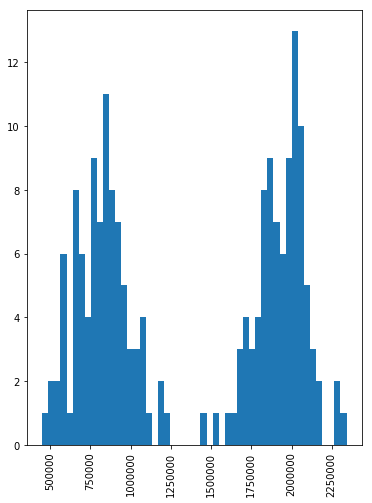

In [33]:
plt.hist(sums_met[3:], bins = 50)
plt.xticks(rotation='vertical')
plt.rcParams["figure.figsize"] = 6, 8
plt.show()

In [34]:
sum_n_b = np.round(GeneExpression_Baseline_normalized.sum(axis=0, numeric_only = True))

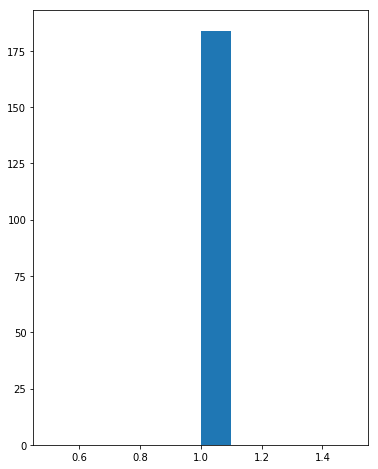

In [35]:
plt.hist(sum_n_b[3:])
#plt.xticks(rotation='vertical')
plt.show()

Other normalization techniques include subtracting the mean, taking the z-score, etc.

**Visual Inspection using heatmap**

In [36]:
scale_bs = pd.DataFrame(GeneExpression_Baseline_normalized.drop(["GeneID", "Chr", "Start", "Stop", "CodingLength"], axis=1))
scale_metf = pd.DataFrame(GeneExpression_Metformin_normalized.drop(["GeneID", "Chr", "Start", "Stop", "CodingLength"], axis=1))

In [37]:
scale_bs["GeneID"] = GeneExpression_Baseline_normalized["GeneID"].values
scale_bs = scale_bs.set_index("GeneID")
scale_bs.head()

,BaselineCell_1,BaselineCell_2,BaselineCell_3,BaselineCell_4,BaselineCell_5,BaselineCell_6,BaselineCell_7,BaselineCell_8,BaselineCell_9,BaselineCell_10,...,BaselineCell_175,BaselineCell_176,BaselineCell_177,BaselineCell_178,BaselineCell_179,BaselineCell_180,BaselineCell_181,BaselineCell_182,BaselineCell_183,BaselineCell_184
GeneID,,,,,,,,,,,,,,,,,,,,,
DDX11L1,0.000034,0.000023,0.000035,0.000038,0.000040,0.000046,0.000039,0.000030,0.000034,0.000055,...,0.000048,0.000046,0.000042,0.000044,0.000053,0.000044,0.000033,0.000044,0.000049,0.000033
WASH7P,0.000040,0.000029,0.000038,0.000040,0.000043,0.000043,0.000051,0.000046,0.000043,0.000044,...,0.000023,0.000039,0.000037,0.000037,0.000029,0.000031,0.000028,0.000047,0.000033,0.000025
FAM138A,0.000088,0.000088,0.000074,0.000066,0.000078,0.000074,0.000061,0.000083,0.000066,0.000073,...,0.000076,0.000045,0.000084,0.000074,0.000068,0.000065,0.000054,0.000050,0.000075,0.000062
FAM138F,0.000035,0.000026,0.000043,0.000046,0.000034,0.000037,0.000043,0.000038,0.000048,0.000045,...,0.000042,0.000049,0.000043,0.000037,0.000033,0.000050,0.000042,0.000044,0.000030,0.000030
OR4F5,0.000034,0.000028,0.000031,0.000030,0.000037,0.000038,0.000046,0.000049,0.000035,0.000033,...,0.000030,0.000051,0.000035,0.000042,0.000036,0.000044,0.000044,0.000040,0.000051,0.000040


In [38]:
scale_metf["GeneID"] = GeneExpression_Metformin_normalized["GeneID"].values
scale_metf = scale_metf.set_index("GeneID")
scale_metf.head()

,MetforminCell_1,MetforminCell_2,MetforminCell_3,MetforminCell_4,MetforminCell_5,MetforminCell_6,MetforminCell_7,MetforminCell_8,MetforminCell_9,MetforminCell_10,...,MetforminCell_175,MetforminCell_176,MetforminCell_177,MetforminCell_178,MetforminCell_179,MetforminCell_180,MetforminCell_181,MetforminCell_182,MetforminCell_183,MetforminCell_184
GeneID,,,,,,,,,,,,,,,,,,,,,
DDX11L1,0.000022,0.000043,0.000035,0.000049,0.000054,0.000026,0.000044,0.000031,0.000053,0.000054,...,0.000031,0.000034,0.000059,0.000036,0.000041,0.000041,0.000035,0.000035,0.000043,0.000057
WASH7P,0.000046,0.000043,0.000054,0.000034,0.000038,0.000032,0.000037,0.000043,0.000041,0.000049,...,0.000038,0.000040,0.000043,0.000047,0.000038,0.000026,0.000035,0.000043,0.000035,0.000043
FAM138A,0.000078,0.000062,0.000070,0.000077,0.000080,0.000065,0.000073,0.000074,0.000072,0.000095,...,0.000064,0.000071,0.000088,0.000064,0.000082,0.000076,0.000088,0.000100,0.000056,0.000057
FAM138F,0.000041,0.000035,0.000043,0.000044,0.000029,0.000051,0.000039,0.000042,0.000037,0.000035,...,0.000038,0.000034,0.000037,0.000053,0.000052,0.000034,0.000038,0.000054,0.000032,0.000054
OR4F5,0.000046,0.000049,0.000037,0.000043,0.000040,0.000037,0.000032,0.000038,0.000038,0.000034,...,0.000023,0.000043,0.000040,0.000038,0.000030,0.000040,0.000037,0.000043,0.000029,0.000032


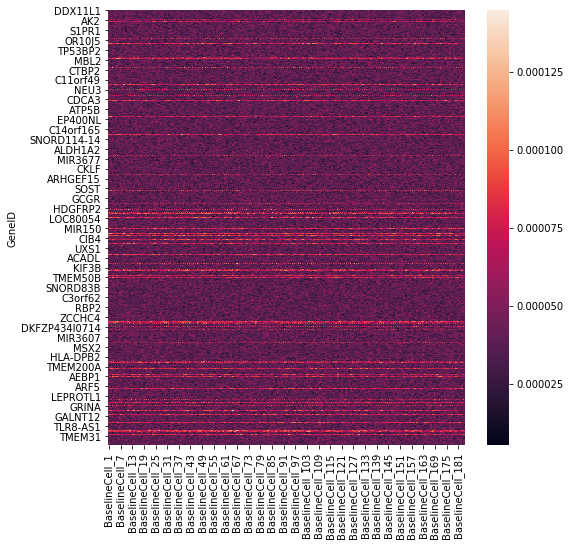

In [39]:
plt.rcParams["figure.figsize"] = 8, 8
sns.heatmap(scale_bs, cbar='BuPu')

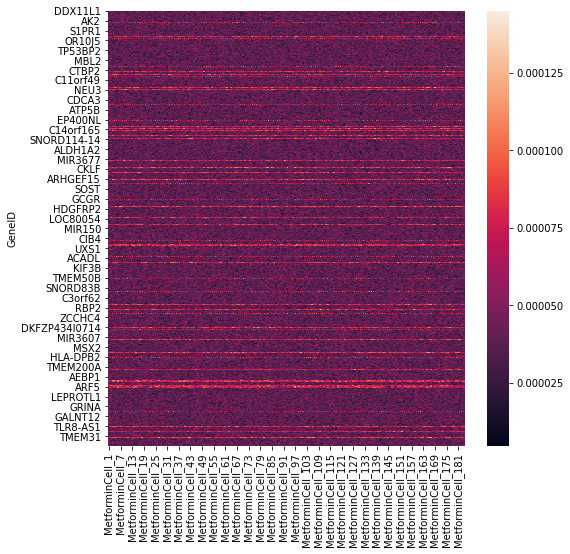

In [40]:
sns.heatmap(scale_metf, cbar='BuPu')

**We plot the distribution of gene expression across all cells for KCND2, TMEM239, and LINC00336, separately**

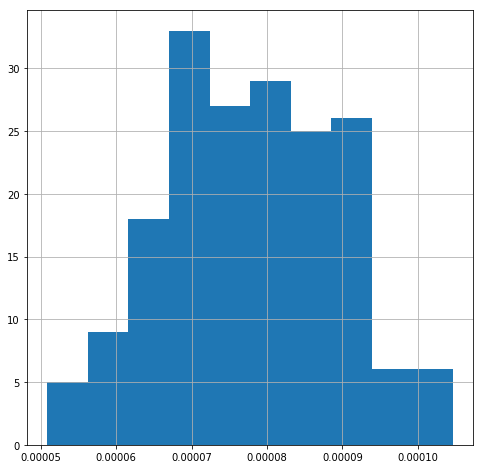

In [41]:
scale_bs.loc["KCND2"].hist()

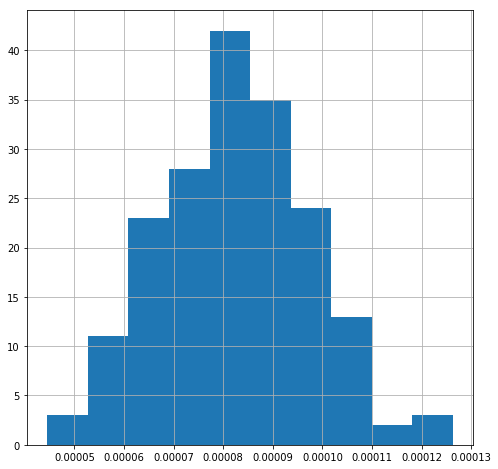

In [42]:
scale_bs.loc["TMEM239"].hist()

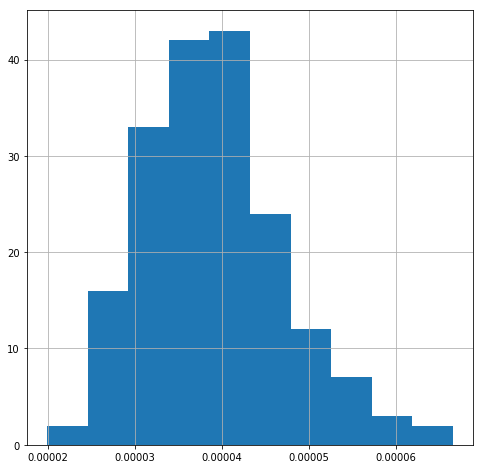

In [43]:
scale_bs.loc["LINC00336"].hist()

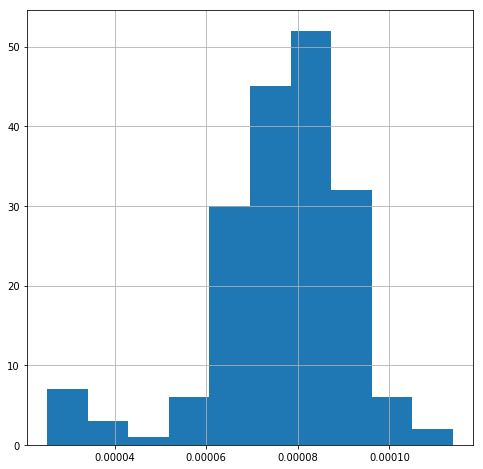

In [44]:
scale_metf.loc["KCND2"].hist()

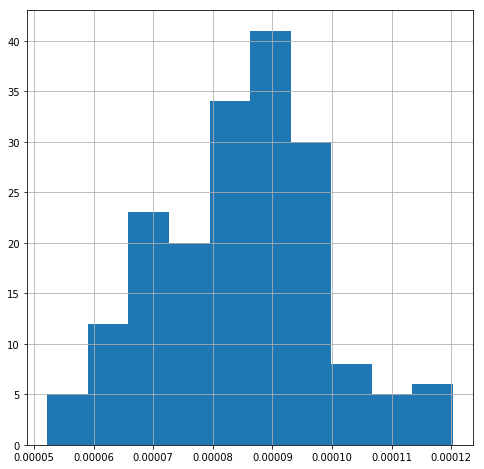

In [45]:
scale_metf.loc["TMEM239"].hist()

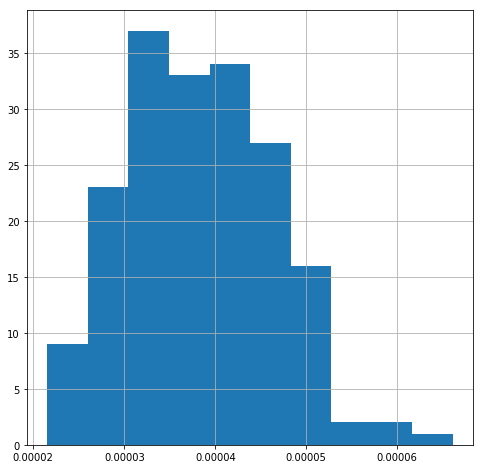

In [46]:
scale_metf.loc["LINC00336"].hist()

**We plot the distribution of gene expression across all genes for BaselineCell_1, BaselineCell_2, MetforminCell_3, and MetforminCell_6, separately.**

In [47]:
temp_base_cell1 = GeneExpression_Baseline_normalized["BaselineCell_1"]
temp_base_cell2 = GeneExpression_Baseline_normalized["BaselineCell_2"]
temp_met_cell3 = GeneExpression_Metformin_normalized["MetforminCell_3"]
temp_met_cell6 = GeneExpression_Metformin_normalized["MetforminCell_6"]

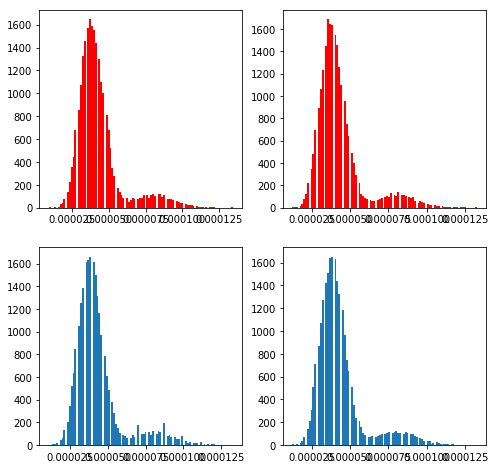

In [48]:
fig, axs = plt.subplots(2, 2)
axs[0,0].hist(temp_base_cell1,bins=100, color='r')
axs[0,1].hist(temp_base_cell2,bins=100, color='r')
axs[1,0].hist(temp_met_cell3,bins=100)
axs[1,1].hist(temp_met_cell6,bins=100)
plt.show()
plt.rcParams["figure.figsize"] = 16, 14

These distributions are approximately Gaussian (there exists a minor hump on the right).

**Statistical Analysis**

A gene’s expression is declared ​altered ​if the difference observed in its expression level between baseline cells and metformin-treated cells is statistically significant.

**1. Kolmogorov–Smirnov (KS) Test**

In [49]:
KS_table = np.empty((GeneExpression_Baseline_normalized.shape[0], 2))

In [50]:
i = 0
for each_row in GeneExpression_Baseline_normalized.iterrows():
    D, p = sp.stats.ks_2samp(GeneExpression_Baseline_normalized.iloc[i,5:],GeneExpression_Metformin_normalized.iloc[i,5:])
    KS_table[i][0] = float(D)
    KS_table[i][1] = float(p)
    i += 1

In [51]:
KS_table

array([[0.05978261, 0.88806428],
       [0.08695652, 0.47219678],
       [0.11956522, 0.13396311],
       ...,
       [0.10326087, 0.26571642],
       [0.04891304, 0.97745567],
       [0.07608696, 0.64435091]])

Null Hypothesis: The values of gene expression before Metformin treatment equals the gene expression after Metformin treatment.
    
For example, the gene expression values of LINC00336 for the 184 cells remains roughly the same before and after Metformin treatment.

**Counting the number of genes with significantly altered expression at alpha=0.1, 0.05, 0.01,
0.005 and 0.001 level:**

In [52]:
alpha = np.empty((5,2))

In [53]:
alpha[0][0] = 0.1
alpha[1][0] = 0.05
alpha[2][0] = 0.01
alpha[3][0] = 0.005
alpha[4][0] = 0.001

In [54]:
for i in range(5):
    count = 0
    for j in KS_table:
        if j[1] < alpha[i][0]:
            count += 1
    alpha[i][1] = count

In [55]:
for i in range(5):
    print(str(alpha[i][0]) + '\t' + str(int(alpha[i][1])))

0.1	2301
0.05	1385
0.01	325
0.005	170
0.001	42


**2. Multiple Testing**

**Based on the definition of p-value, if the null hypothesis is true, then the p-values must follow the uniform distribution.**

In [56]:
p_list = []
for each_row in KS_table:
    p_list.append(each_row[1])

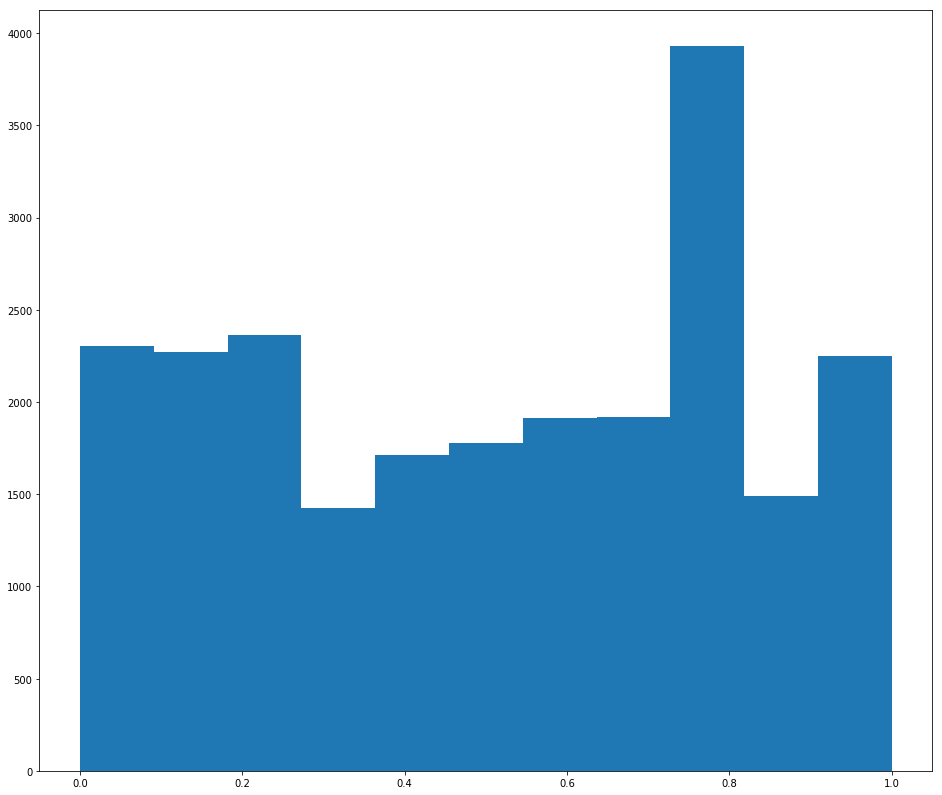

In [57]:
plt.hist(p_list,bins=11)
plt.show()
plt.rcParams["figure.figsize"] = 6, 6

In [58]:
m = GeneExpression_Baseline_normalized.shape[0]
under_null = [0.1*m, 0.05*m, 0.01*m, 0.005*m, 0.001*m]

In [59]:
print("Signif level\tActual\t    Expected under H0")
for i in range(5):
    print(str(alpha[i][0]) + '\t\t' + str(int(alpha[i][1])) + '\t\t' + str(int(under_null[i])))

Signif level	Actual	    Expected under H0
0.1		2301		2334
0.05		1385		1167
0.01		325		233
0.005		170		116
0.001		42		23


**Q-Q (quantile-quantile) plot:**

In [60]:
rand_vals = np.random.uniform(0,1,m)

rand_vals = -1*np.log10(rand_vals)

rand_vals

array([0.01760665, 0.31142556, 0.78366213, ..., 1.06823333, 0.30163281,
       2.21819034])

In [61]:
actual_vals = KS_table[:,1].copy()

actual_vals = -1*np.log10(actual_vals)

actual_vals

array([0.0515556 , 0.32587698, 0.87301478, ..., 0.5755816 , 0.00990293,
       0.19087756])

In [62]:
rand_vals = np.sort(rand_vals)
actual_vals = np.sort(actual_vals)

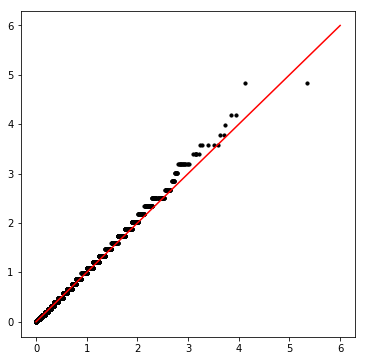

In [63]:
plt.scatter(rand_vals, actual_vals, s=10, color='k')
x=[0,1,2,3,4,5,6]
y=[0,1,2,3,4,5,6]
plt.plot(x,y,color='r')
plt.rcParams["figure.figsize"] = 8, 8
plt.show()

We conclude that there is **no signifact** evidence that there was any change in the gene expressions after treatment with Metformin.

**Task 3: Dimensionality Reduction and Clustering**

In this task, you will apply clustering techniques to find out subpopulations of cells.

The results in Task 2.2.e. is related to the heterogeneity of cells. For example, the ~200 baseline cells might comprise multiple subpopulations and the response to metformin might differ between or even within such subpopulations (after all, cell responses are stochastic processes.) Which is to say, metformin might have only induced alterations in the expression levels of crucial genes in a subpopulation of cells instead of all cells. **Thus, it is essential to first identify such subpopulations before running statistical tests.**

Identifying subpopulations based on cells’ gene expression profiles is essentially an unsupervised clustering problem. That is to identify clusters of cells based on the similarities of their gene expression profiles. This is a difficult problem because: 1) The number of clusters is not known a priori, 2) There is usually high level of noise in the data (both technical and biological), and 3) The number of dimensions (i.e. genes) is large.

When working with high-dimensional datasets such as gene expression matrices, it can often be beneficial to apply some sort of dimensionality reduction method. Projecting the data onto a lower-dimensional subspace could substantially reduce the amount of noise. An additional benefit is that it is typically much easier to visualize the data in a 2 or 3-dimensional subspace. Therefore, we will be performing Principal Component Analysis to reduce the dimensionalities of the gene expression matrices.

**1. Principal Component Analysis (PCA)**

The easiest way to visualize the data is by transforming it using PCA and then visualizing the firsttwoprincipalcomponents.**Note:** PCA,plotting,andcalculationshouldbedoneseparately for baseline cells and metformin-treated cells.

**a. Treating cells as samples and genes as features (dimensions), perform PCA on the gene expression data. (Hint: make use of the decomposition.PCA API in the sklearn package. Select “full” for svd_solver.)**

We treat cells as samples and genes as the attributes.

In [64]:
metf_matrix = scale_metf.as_matrix()
bs_matrix = scale_bs.as_matrix()

/Users/nihithindlekar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/Users/nihithindlekar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [65]:
metf_matrix.shape

(23346, 184)

In [66]:
bs_matrix.shape

(23346, 184)

In [67]:
metf_matrix_T = metf_matrix.transpose()

In [68]:
bs_matrix_T = bs_matrix.transpose()

In [69]:
bs_matrix_T.shape

(184, 23346)

In [70]:
metf_matrix_T.shape

(184, 23346)

In [71]:
from sklearn.decomposition import PCA

In [72]:
pca_bs = PCA(svd_solver='full')
pca_bs.fit(bs_matrix_T)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

In [73]:
pca_metf = PCA(svd_solver='full')
pca_metf.fit(metf_matrix_T)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

In [74]:
per_var_bs = np.round(pca_bs.explained_variance_ratio_ * 100, decimals = 3)
per_var_metf = np.round(pca_metf.explained_variance_ratio_ * 100, decimals = 3)

In [75]:
pca_data_bs = pca_bs.transform(bs_matrix_T)
pca_data_metf = pca_metf.transform(metf_matrix_T)

In [76]:
pca_comp_num = []
for i in range(1, 185):
    pca_comp_num.append(i)

**b. Order the principal components by decreasing contribution to total variance. Plot a scree plot to show the fraction of total variance in the data as explained by each principal component. How many principal components are needed in order to explain 30% of the total variance?**

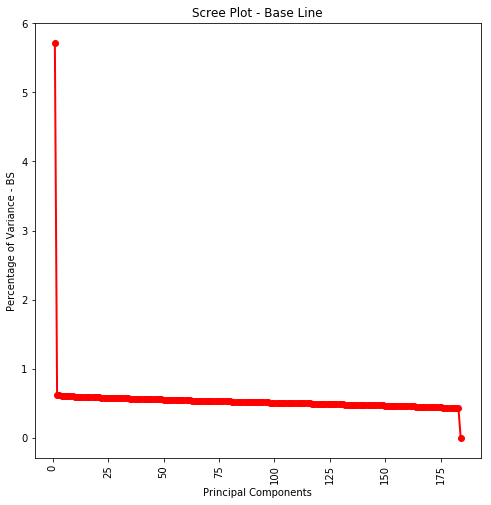

In [77]:
labels = ['PC' + str(x) for x in range(1, len(per_var_bs)+1)]
#plt.bar(x = range(1, len(per_var_bs)+1), height = per_var_bs, tick_label = labels)
plt.plot(pca_comp_num, per_var_bs, 'ro-', linewidth=2)
plt.ylabel("Percentage of Variance - BS")
plt.xlabel("Principal Components")
plt.title("Scree Plot - Base Line")
plt.xticks(rotation='vertical')
plt.rcParams["figure.figsize"] = 20, 20
plt.show()

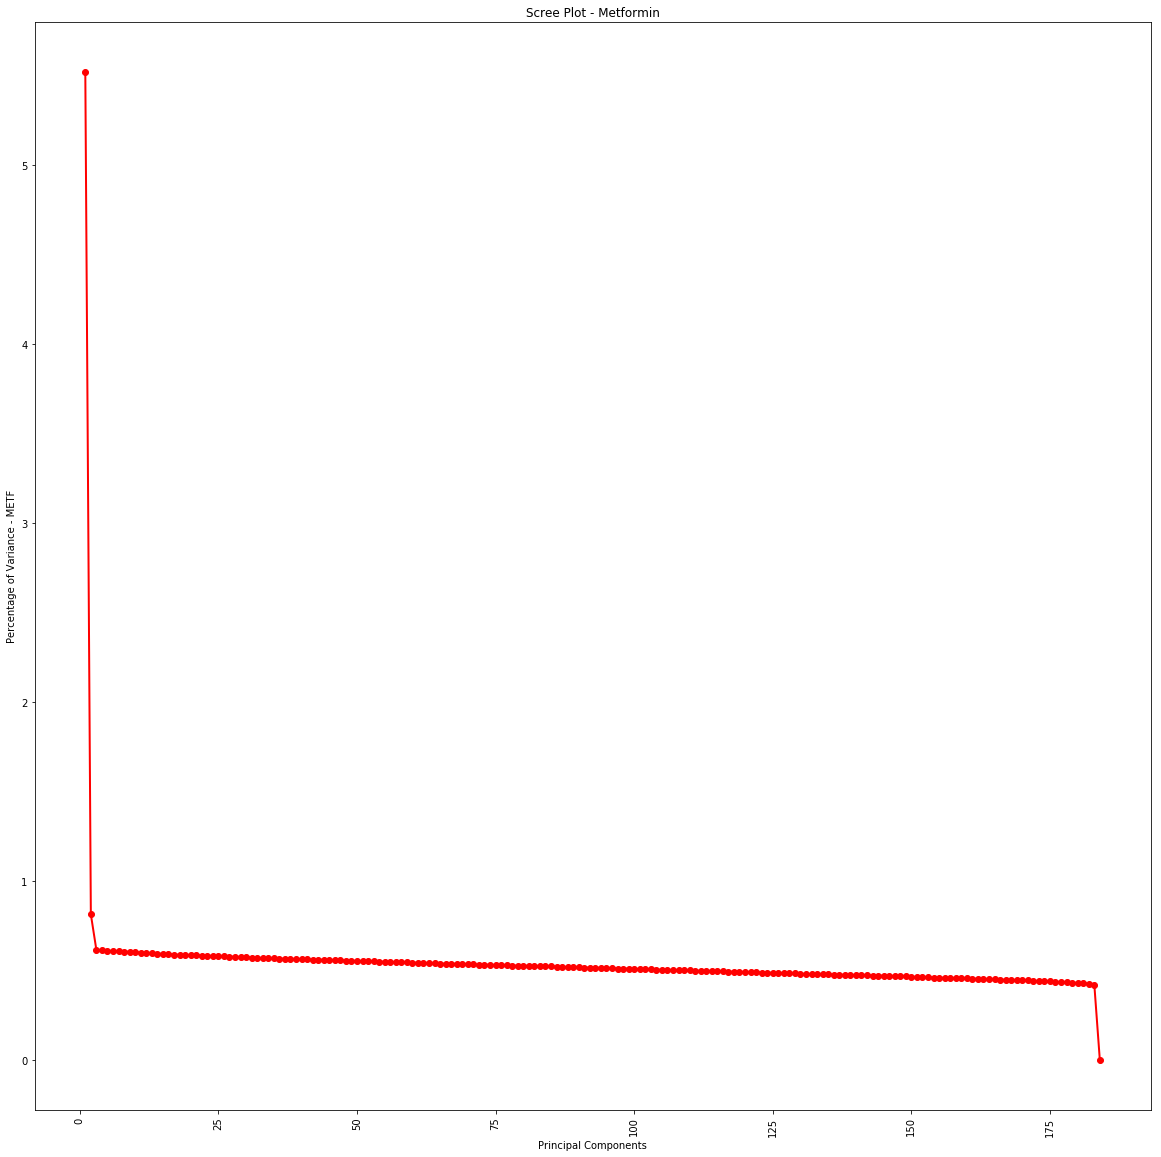

In [78]:
labels = ['PC' + str(x) for x in range(1, len(per_var_metf)+1)]
#plt.bar(x = range(1, len(per_var_metf)+1), height = per_var_metf, tick_label = labels)
plt.plot(pca_comp_num, per_var_metf, 'ro-', linewidth=2)
plt.ylabel("Percentage of Variance - METF")
plt.xlabel("Principal Components")
plt.title("Scree Plot - Metformin")
plt.xticks(rotation='vertical')
plt.rcParams["figure.figsize"] = 10, 8
plt.show()

In [79]:
i = 0
total_percent = 0
while total_percent < 30:
    total_percent += per_var_bs[i]
    i += 1
print('Components required for 30 percent variance for BS: ' + str(i))

Components required for 30 percent variance for BS: 43


In [80]:
i = 0
total_percent = 0
while total_percent < 30:
    total_percent += per_var_metf[i]
    i += 1
print('Components required for 30 percent variance for METF: ' + str(i))

Components required for 30 percent variance for METF: 43


**c. Plot a scatter plot of the gene expression with the first two components. Briefly summarize your observations.**

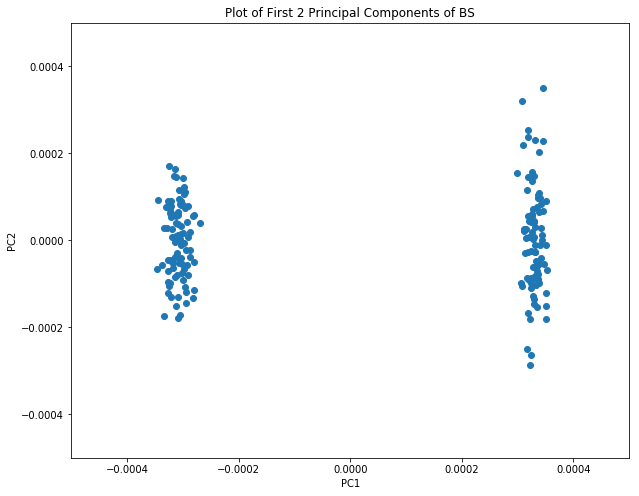

In [81]:
plt.scatter(pca_data_bs[:,0], pca_data_bs[:,1])
plt.rcParams["figure.figsize"] = 10, 10
plt.xlim(-0.00050, 0.00050)
plt.ylim(-0.00050, 0.00050)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Plot of First 2 Principal Components of BS")
plt.show()

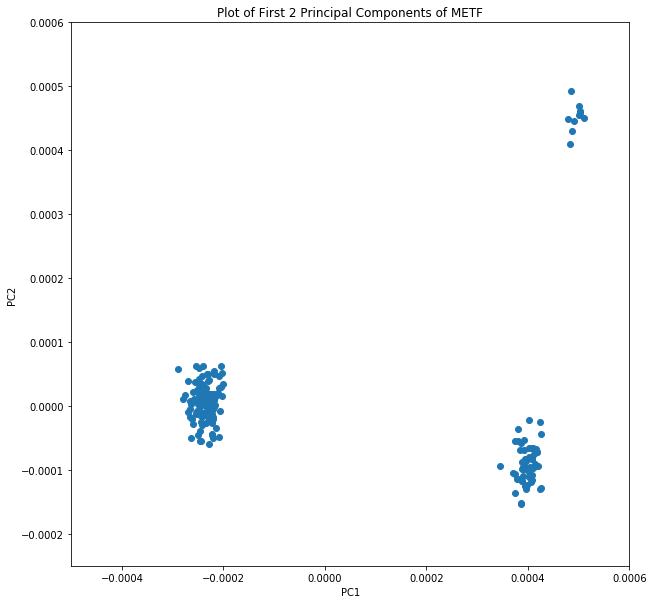

In [82]:
plt.scatter(pca_data_metf[:,0], pca_data_metf[:,1])
plt.rcParams["figure.figsize"] = 10, 10
plt.xlim(-0.00050, 0.00060)
plt.ylim(-0.00025, 0.00060)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Plot of First 2 Principal Components of METF")
plt.show()

**2. t-Distributed Stochastic Neighbor Embedding (t-SNE)**

t-SNE is a popular dimensionality reduction technique for visualization. t-SNE models each high-dimensional object by a two- or three-dimensional point such that similar projects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability. We are not expecting you to know t-SNE in detail, but it is useful to know how to run t-SNE with a package and interpret the results.

a. Treating cells as samples and genes as features (dimensions), perform t-SNE to visualizethegeneexpressiondatain2D.(Hint: make use of the manifold. TSNE API in the scikit-learn package) t-SNE and plotting should be done for baseline cells and metformin-treated cells separately. Briefly summarize your observations.

b. Compare the results of PCA and t-SNE.

In [83]:
from sklearn.manifold import TSNE

In [84]:
X_embedded_bs = TSNE(n_components=2).fit_transform(bs_matrix_T)
X_embedded_bs.shape

(184, 2)

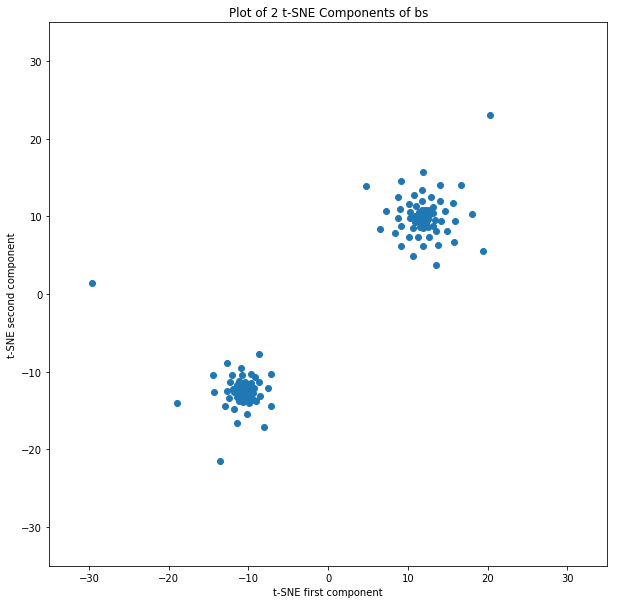

In [85]:
plt.scatter(X_embedded_bs[:,0], X_embedded_bs[:,1])
plt.rcParams["figure.figsize"] = 10, 10
plt.xlim(-35,  35)
plt.ylim(-35,  35)
plt.xlabel("t-SNE first component")
plt.ylabel("t-SNE second component")
plt.title("Plot of 2 t-SNE Components of bs")
plt.show()

In [86]:
X_embedded_metf = TSNE().fit_transform(metf_matrix_T)
X_embedded_metf.shape

(184, 2)

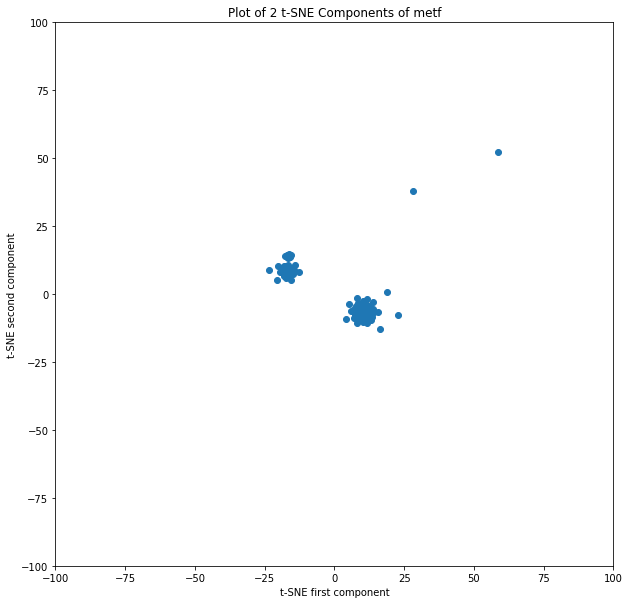

In [87]:
plt.scatter(X_embedded_metf[:,0], X_embedded_metf[:,1])
plt.rcParams["figure.figsize"] = 10, 10
plt.xlim(-100,  100)
plt.ylim(-100,  100)
plt.xlabel("t-SNE first component")
plt.ylabel("t-SNE second component")
plt.title("Plot of 2 t-SNE Components of metf")
plt.show()

We observe that, for the the Metformin-treated cells the first 2 components of PCA fors 3 clusters. Whereas, the first 2 components of t-SNE dimension reduction forms only 2 clusters.

**3. Clustering**

We now performing clustering to identify the subpopulations of cells. For the purpose of this project, clustering should be performed after projecting the data into 2D using PCA (Task 3.1.a.). Note: In reality, various factors go into determining the number of dimensions to retain after PCA.

Baseline cells and metformin-treated cells should be clustered separately. Visualize your results by plotting a 2D scatter plot just like you did in Task 3.1.c., but with each point colored by the clusters they belong to (use different colors for different clusters). For all clustering algorithms below, you will need to decide the optimal number of clusters by yourself and reason about it. Provide numbers, tables and/or graphs to support your reasoning.

**a. K-Means Clustering**

In [88]:
from sklearn.cluster import KMeans

In [89]:
np.random.seed(1)
kmeans_bs = KMeans(n_clusters=2, random_state=0).fit(pca_data_bs[:,:2])

In [90]:
kmeans_bs.cluster_centers_

array([[ 3.29577881e-04,  1.73628692e-07],
       [-3.08762436e-04, -1.62662669e-07]])

In [91]:
np.random.seed(1)
kmeans_metf = KMeans(n_clusters=3, random_state=0).fit(pca_data_metf[:,:2])
kmeans_metf.cluster_centers_

array([[-2.36199548e-04,  5.93344087e-06],
       [ 3.98110235e-04, -9.14401602e-05],
       [ 4.94306372e-04,  4.51787655e-04]])

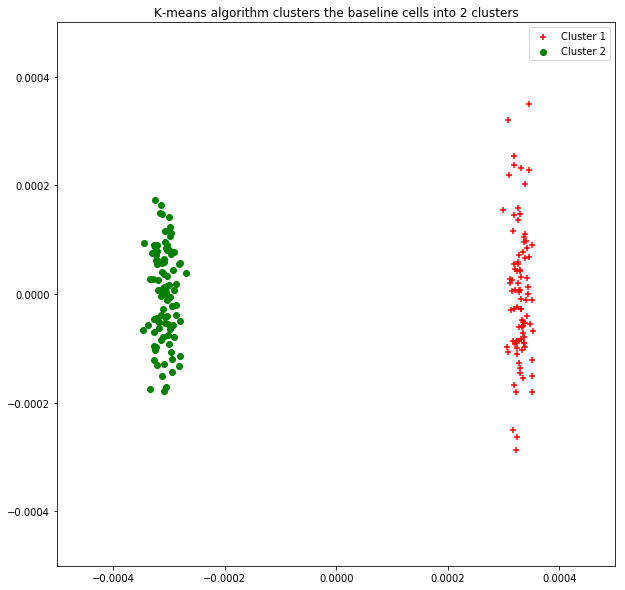

In [92]:
for i in range(0, pca_data_bs.shape[0]):
    if kmeans_bs.labels_[i] == 0:
        c1 = plt.scatter(pca_data_bs[i,0],pca_data_bs[i,1],c='r',marker='+')
    elif kmeans_bs.labels_[i] == 1:
        c2 = plt.scatter(pca_data_bs[i,0],pca_data_bs[i,1],c='g',marker='o')
plt.legend([c1, c2],['Cluster 1', 'Cluster 2'])
plt.title('K-means algorithm clusters the baseline cells into 2 clusters')
plt.xlim(-0.00050, 0.00050)
plt.ylim(-0.00050, 0.00050)
plt.show()

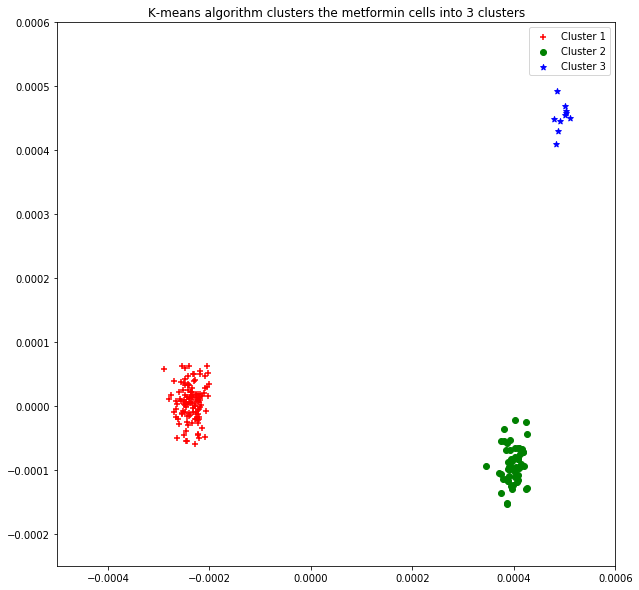

In [93]:
for i in range(0, pca_data_metf.shape[0]):
    if kmeans_metf.labels_[i] == 0:
        c1 = plt.scatter(pca_data_metf[i,0],pca_data_metf[i,1],c='r',marker='+')
    elif kmeans_metf.labels_[i] == 1:
        c2 = plt.scatter(pca_data_metf[i,0],pca_data_metf[i,1],c='g',marker='o')
    elif kmeans_metf.labels_[i] == 2:
        c3 = plt.scatter(pca_data_metf[i,0],pca_data_metf[i,1],c='b',marker='*')
plt.legend([c1, c2, c3],['Cluster 1', 'Cluster 2', 'Cluster 3'])
plt.title('K-means algorithm clusters the metformin cells into 3 clusters')
plt.xlim(-0.00050, 0.00060)
plt.ylim(-0.00025, 0.00060)
plt.show()

**b. Gaussian Mixture Model Clustering (Hint: You might run into numerical issues if you use the GMM implementation in scikit-learn. You might want to try scaling up the data 100 or 1000 times if your results look weird.)**

In [94]:
from sklearn.mixture import GaussianMixture
gmm_bs = GaussianMixture(n_components=2).fit(pca_data_bs[:,:2]*1000)
labels_bs = gmm_bs.predict(pca_data_bs[:,:2]*1000)
labels_bs

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1])

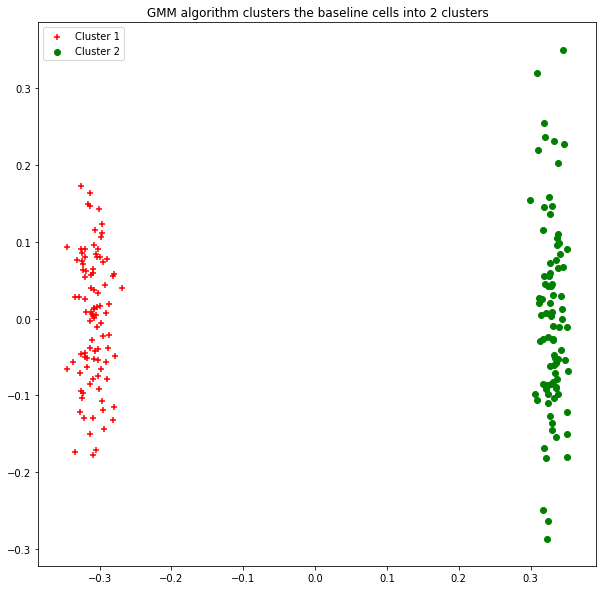

In [95]:
for i in range(0, pca_data_bs.shape[0]):
    if labels_bs[i] == 0:
        c1 = plt.scatter(pca_data_bs[i,0]*1000,pca_data_bs[i,1]*1000,c='r',marker='+')
    elif labels_bs[i] == 1:
        c2 = plt.scatter(pca_data_bs[i,0]*1000,pca_data_bs[i,1]*1000,c='g',marker='o')
plt.legend([c1, c2],['Cluster 1', 'Cluster 2'])
plt.title('GMM algorithm clusters the baseline cells into 2 clusters')
#plt.xlim(-0.00050, 0.00060)
#plt.ylim(-0.00025, 0.00060)
plt.show()

In [96]:
gmm_metf = GaussianMixture(n_components=3).fit(pca_data_metf[:,:2]*1000)
labels_metf = gmm_metf.predict(pca_data_metf[:,:2]*1000)

In [97]:
labels_metf

array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       2, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 2, 1, 0, 2, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 2, 2, 0, 1, 2, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1])

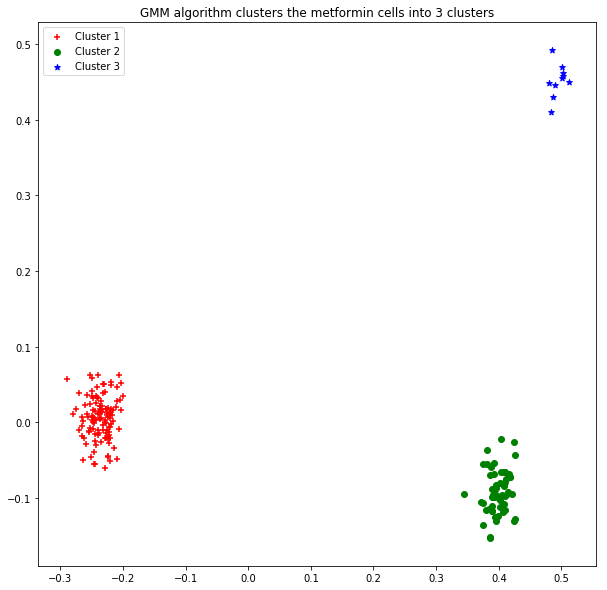

In [98]:
for i in range(0, pca_data_metf.shape[0]):
    if labels_metf[i] == 0:
        c1 = plt.scatter(pca_data_metf[i,0]*1000,pca_data_metf[i,1]*1000,c='r',marker='+')
    elif labels_metf[i] == 1:
        c2 = plt.scatter(pca_data_metf[i,0]*1000,pca_data_metf[i,1]*1000,c='g',marker='o')
    elif labels_metf[i] == 2:
        c3 = plt.scatter(pca_data_metf[i,0]*1000,pca_data_metf[i,1]*1000,c='b',marker='*')
plt.legend([c1, c2, c3],['Cluster 1', 'Cluster 2', 'Cluster 3'])
plt.title('GMM algorithm clusters the metformin cells into 3 clusters')
#plt.xlim(-0.00050, 0.00060)
#plt.ylim(-0.00025, 0.00060)
plt.show()

**c. Single Linkage Hierarchical Clustering:**

In [99]:
from sklearn.cluster import AgglomerativeClustering

In [100]:
singlelink = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
singlelink.fit_predict(pca_data_bs[:,:2])

array([1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0])

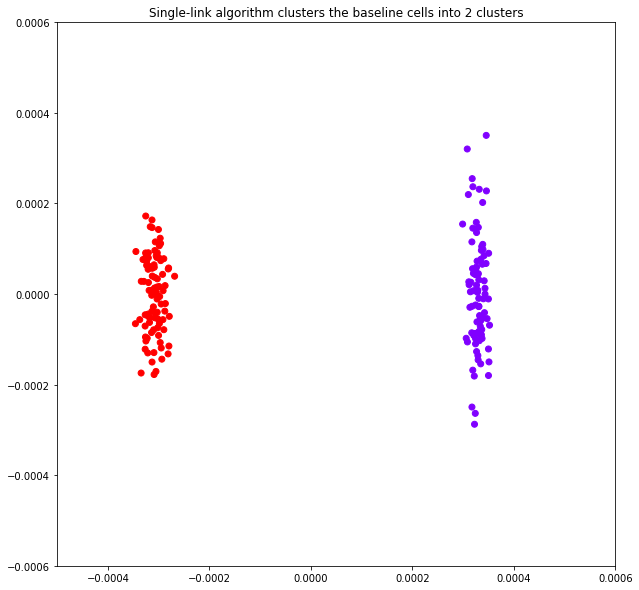

In [101]:
plt.scatter(pca_data_bs[:,0],pca_data_bs[:,1], c=singlelink.labels_, cmap='rainbow')
plt.title('Single-link algorithm clusters the baseline cells into 2 clusters')
plt.xlim(-0.00050, 0.00060)
plt.ylim(-0.00060, 0.00060)
plt.show()

In [102]:
singlelink_m = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
singlelink_m.fit_predict(pca_data_metf[:,:2])

array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       2, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 2, 1, 0, 2, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 2, 2, 0, 1, 2, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1])

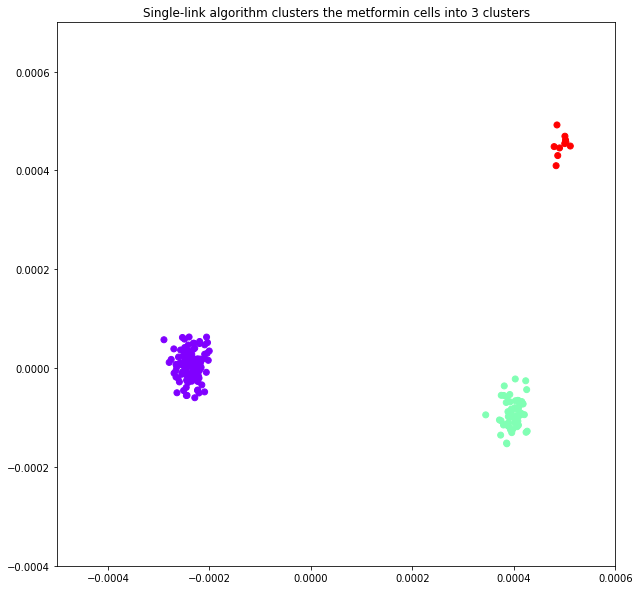

In [103]:
plt.scatter(pca_data_metf[:,0],pca_data_metf[:,1], c=singlelink_m.labels_, cmap='rainbow')
plt.title('Single-link algorithm clusters the metformin cells into 3 clusters')
plt.xlim(-0.00050, 0.00060)
plt.ylim(-0.00040, 0.00070)
plt.show()

**d. Compare your results for different clustering methods and interpret them. Pick the results
from your favorite one for the following analyses.**

We see that k is a hyper-parameter for all 3 of the clustering models. However, the Gaussian Mixture model also assumes that the distribution of each cluster is Gaussian. Therefore, GMM is more restrictive than the other two models.

**Task 4: Interpret Results**

In this task, you are going to identify the set of genes with significantly altered expression and their associated pathways.

**1. Identify altered genes**

For each subpopulation (cluster) $M_i$ in the metformin-treated cells, there are two possibilities: 1) The cells in $M_i$ are not affected by metformin. Thus, they have the same gene expression profile as one of the subpopulations in the baseline cells. Consequently, $M_i$ will be identical to one of the baseline subpopulations, while being distinctively different from the other subpopulations.

2) For cells in $M_i$, the expression levels of ~50-400 genes were altered by metformin. Thus, they have similar gene expression profiles as one of the subpopulations in the baseline cells, but not entirely the same. Consequently, $M_i$ will be more similar to one of the baseline subpopulations compared to the other subpopulations, but not identical to any of them.

Based on the above information, answer the following questions:

**a. For each metformin-treated subpopulations, determine whether or not it is affected by
metformin. Show and explain your decision process in detail. Provide numbers, tables
and/or graphs where necessary.**

In [104]:
bs_matrix_T[5:10]

array([[4.58489735e-05, 4.28588230e-05, 7.37570443e-05, ...,
        3.38883717e-05, 4.28588230e-05, 3.68785221e-05],
       [3.93325793e-05, 5.10260488e-05, 6.05934329e-05, ...,
        3.50804085e-05, 3.93325793e-05, 3.29543232e-05],
       [3.00516593e-05, 4.58164642e-05, 8.27652256e-05, ...,
        4.43385137e-05, 3.79340617e-05, 4.92650152e-05],
       [3.36695563e-05, 4.31206599e-05, 6.61577247e-05, ...,
        3.54416383e-05, 3.54416383e-05, 2.77626166e-05],
       [5.47459388e-05, 4.40638044e-05, 7.34396740e-05, ...,
        4.13932708e-05, 3.33816700e-05, 4.53990712e-05]])

In [105]:
metf_matrix_T[5:10]

array([[2.59188922e-05, 3.23986153e-05, 6.47972306e-05, ...,
        3.50984999e-05, 3.83383614e-05, 3.99582922e-05],
       [4.44349185e-05, 3.71162261e-05, 7.26641609e-05, ...,
        2.45698961e-05, 4.28666273e-05, 4.60032098e-05],
       [3.08524231e-05, 4.30954481e-05, 7.39478712e-05, ...,
        3.67290751e-05, 4.45646111e-05, 2.88935391e-05],
       [5.25128542e-05, 4.10970164e-05, 7.19197786e-05, ...,
        4.10970164e-05, 4.90881029e-05, 3.19643461e-05],
       [5.37201440e-05, 4.94033467e-05, 9.54491843e-05, ...,
        2.44618513e-05, 2.59007837e-05, 3.21361575e-05]])

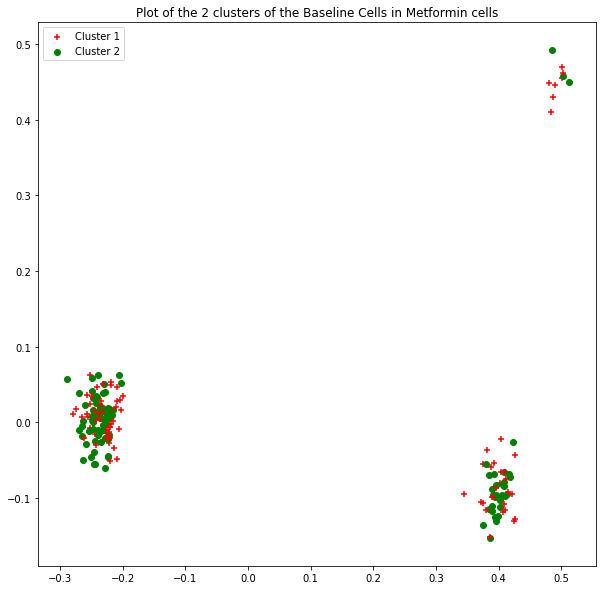

In [106]:
for i in range(0, pca_data_metf.shape[0]):
    if kmeans_bs.labels_[i] == 0:
        c1 = plt.scatter(pca_data_metf[i,0]*1000,pca_data_metf[i,1]*1000,c='r',marker='+')
    elif kmeans_bs.labels_[i] == 1:
        c2 = plt.scatter(pca_data_metf[i,0]*1000,pca_data_metf[i,1]*1000,c='g',marker='o')
plt.legend([c1, c2],['Cluster 1', 'Cluster 2'])
plt.title('Plot of the 2 clusters of the Baseline Cells in Metformin cells')
#plt.xlim(-0.00050, 0.00060)
#plt.ylim(-0.00025, 0.00060)
plt.show()

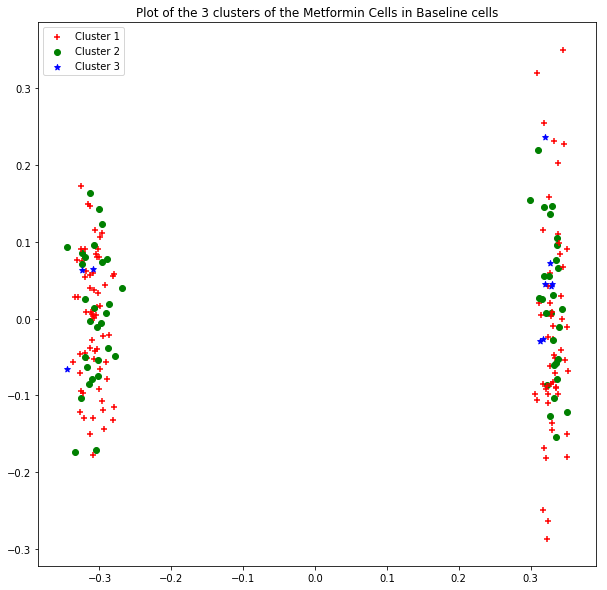

In [107]:
for i in range(0, pca_data_metf.shape[0]):
    if kmeans_metf.labels_[i] == 0:
        c1 = plt.scatter(pca_data_bs[i,0]*1000,pca_data_bs[i,1]*1000,c='r',marker='+')
    elif kmeans_metf.labels_[i] == 1:
        c2 = plt.scatter(pca_data_bs[i,0]*1000,pca_data_bs[i,1]*1000,c='g',marker='o')
    elif kmeans_metf.labels_[i] == 2:
        c3 = plt.scatter(pca_data_bs[i,0]*1000,pca_data_bs[i,1]*1000,c='b',marker='*')
plt.legend([c1, c2, c3],['Cluster 1', 'Cluster 2', 'Cluster 3'])
plt.title('Plot of the 3 clusters of the Metformin Cells in Baseline cells')
#plt.xlim(-0.00050, 0.00060)
#plt.ylim(-0.00025, 0.00060)
plt.show()

**So we conclude that, just from the plot of the clusters it is impossible to tell which clusters comprise cells which altered after treatment***

Therefore, we perform statistical KS tests:

In [108]:
metf_matrix_class_0 = []
metf_matrix_class_1 = []
metf_matrix_class_2 = []
bs_matrix_class_0 = []
bs_matrix_class_1 = []
bs_matrix_class_2 = []
for i in range(0, pca_data_metf.shape[0]):
    if kmeans_metf.labels_[i] == 0:
        metf_matrix_class_0.append(metf_matrix_T[i])
        bs_matrix_class_0.append(bs_matrix_T[i])
    elif kmeans_metf.labels_[i] == 1:
        metf_matrix_class_1.append(metf_matrix_T[i])
        bs_matrix_class_1.append(bs_matrix_T[i])
    elif kmeans_metf.labels_[i] == 2:
        metf_matrix_class_2.append(metf_matrix_T[i])
        bs_matrix_class_2.append(bs_matrix_T[i])

In [109]:
metf_matrix_class_0_m = np.array(metf_matrix_class_0)
metf_matrix_class_1_m = np.array(metf_matrix_class_1)
metf_matrix_class_2_m = np.array(metf_matrix_class_2)
bs_matrix_class_0_m = np.array(bs_matrix_class_0)
bs_matrix_class_1_m = np.array(bs_matrix_class_1)
bs_matrix_class_2_m = np.array(bs_matrix_class_2)

In [110]:
KS_class_0 = []
i = 0
while i < len(metf_matrix_class_0_m[0]):
    D, p = sp.stats.ks_2samp(metf_matrix_class_0_m[:,i],bs_matrix_class_0_m[:,i])
    KS_class_0.append(p)
    i += 1   

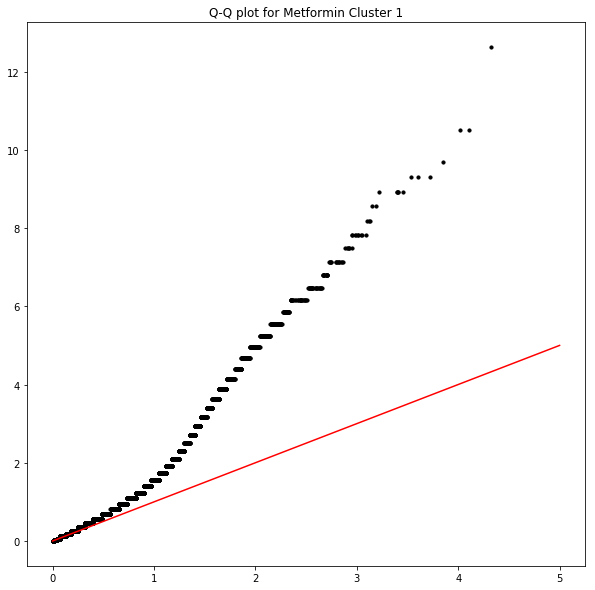

In [111]:
rand_vals_0 = np.random.uniform(0,1,len(metf_matrix_class_0_m[0]))
rand_vals_0 = -1*np.log10(rand_vals_0)
actual_vals_0 = -1*np.log10(KS_class_0)
rand_vals_0 = np.sort(rand_vals_0)
actual_vals_0 = np.sort(actual_vals_0)
plt.scatter(rand_vals_0, actual_vals_0, s=10, color='k')
x=[0,1,2,3,4,5]
y=[0,1,2,3,4,5]
plt.plot(x,y,color='r')
plt.title("Q-Q plot for Metformin Cluster 1")
plt.rcParams["figure.figsize"] = 8, 8
plt.show()

In [112]:
KS_class_1 = []
i = 0
while i < len(metf_matrix_class_1_m[0]):
    D, p = sp.stats.ks_2samp(metf_matrix_class_1_m[:,i],bs_matrix_class_1_m[:,i])
    KS_class_1.append(p)
    i += 1 

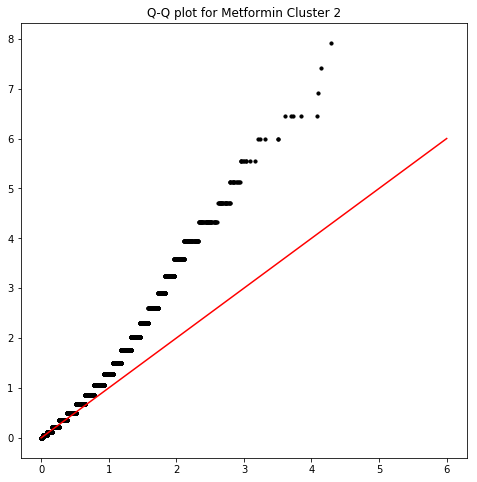

In [113]:
rand_vals_1 = np.random.uniform(0,1,len(metf_matrix_class_1_m[0]))
rand_vals_1 = -1*np.log10(rand_vals_1)
actual_vals_1 = -1*np.log10(KS_class_1)
rand_vals_1 = np.sort(rand_vals_1)
actual_vals_1 = np.sort(actual_vals_1)
plt.scatter(rand_vals_1, actual_vals_1, s=10, color='k')
x=[0,1,2,3,4,5,6]
y=[0,1,2,3,4,5,6]
plt.plot(x,y,color='r')
plt.title("Q-Q plot for Metformin Cluster 2")
plt.rcParams["figure.figsize"] = 8, 8
plt.show()

In [114]:
KS_class_2 = []
i = 0
while i < len(metf_matrix_class_2_m[0]):
    D, p = sp.stats.ks_2samp(metf_matrix_class_2_m[:,i],bs_matrix_class_2_m[:,i])
    KS_class_2.append(p)
    i += 1 

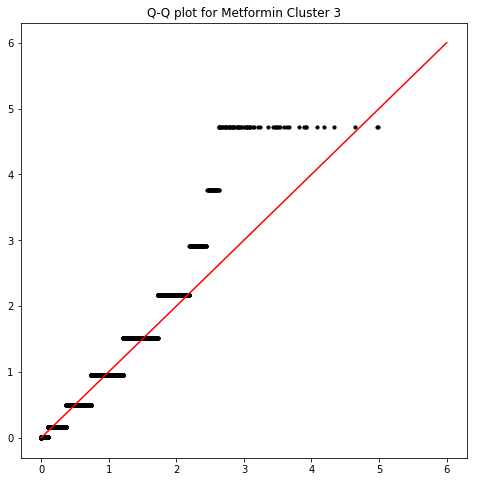

In [115]:
rand_vals_2 = np.random.uniform(0,1,len(metf_matrix_class_2_m[0]))
rand_vals_2 = -1*np.log10(rand_vals_2)
actual_vals_2 = -1*np.log10(KS_class_2)
rand_vals_2 = np.sort(rand_vals_2)
actual_vals_2 = np.sort(actual_vals_2)
plt.scatter(rand_vals_2, actual_vals_2, s=10, color='k')
x=[0,1,2,3,4,5,6]
y=[0,1,2,3,4,5,6]
plt.plot(x,y,color='r')
plt.title("Q-Q plot for Metformin Cluster 3")
plt.rcParams["figure.figsize"] = 8, 8
#plt.ylim(-0.00025, 12)
plt.show()

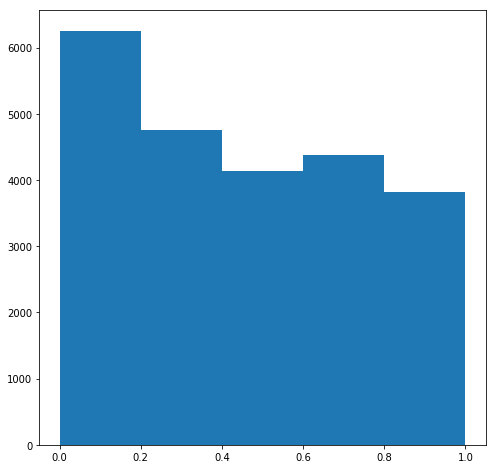

In [116]:
plt.hist(KS_class_0,bins=5)
plt.show()
plt.rcParams["figure.figsize"] = 6, 6

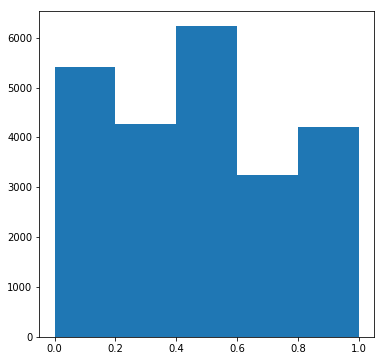

In [117]:
plt.hist(KS_class_1,bins=5)
plt.show()
plt.rcParams["figure.figsize"] = 6, 6

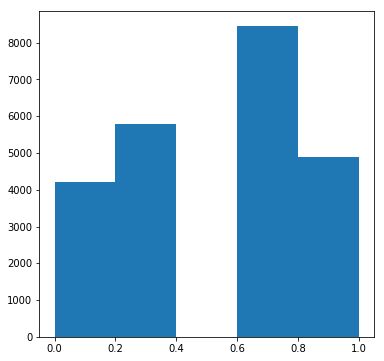

In [118]:
plt.hist(KS_class_2,bins=5)
plt.show()
plt.rcParams["figure.figsize"] = 6, 6

In [119]:
count = 0
for i in KS_class_0:
    if i < 0.0000025:
        count += 1
print(count)

137


In [120]:
count = 0
for i in KS_class_1:
    if i < 0.0000025:
        count += 1
print(count)

13


In [121]:
count = 0
for i in KS_class_2:
    if i < 0.0000025:
        count += 1
print(count)

0


**Since, custer $M_{1_{Metformin}}$ has 137 altered genes (> 50), we conclude that $M_{1_{Metformin}}$ is the only altered clustered.**


**b. For each affected subpopulations $M_i$ identify the baseline subpopulation that $M_i$ is most
similar to. Show and explain your decision process in detail. Provide numbers, tables
and/or graphs where necessary.**

In [122]:
metf_matrix_class_1_bs_class_0 = []
metf_matrix_class_1_bs_class_1 = []
bs_matrix_class_0_metf_class_1 = []
bs_matrix_class_1_metf_class_1 = []
for i in range(0, pca_data_metf.shape[0]):
    if kmeans_metf.labels_[i] == 0:
        if kmeans_bs.labels_[i] == 0:
            metf_matrix_class_1_bs_class_0.append(metf_matrix_T[i])
            bs_matrix_class_0_metf_class_1.append(bs_matrix_T[i])
        elif kmeans_bs.labels_[i] == 1:
            metf_matrix_class_1_bs_class_1.append(metf_matrix_T[i])
            bs_matrix_class_1_metf_class_1.append(bs_matrix_T[i])

In [123]:
metf_matrix_class_1_bs_class_0_m = np.array(metf_matrix_class_1_bs_class_0)
bs_matrix_class_0_metf_class_1_m = np.array(bs_matrix_class_0_metf_class_1)
metf_matrix_class_1_bs_class_1_m = np.array(metf_matrix_class_1_bs_class_1)
bs_matrix_class_1_metf_class_1_m = np.array(bs_matrix_class_1_metf_class_1)

In [124]:
KS_class_m1_b0 = []
i = 0
while i < len(metf_matrix_class_1_bs_class_0_m[0]):
    D, p = sp.stats.ks_2samp(metf_matrix_class_1_bs_class_0_m[:,i],bs_matrix_class_0_metf_class_1_m[:,i])
    KS_class_m1_b0.append(p)
    i += 1

In [125]:
count = 0
for i in KS_class_m1_b0:
    if i < 0.0000025:
        count += 1
print(count)

769


In [126]:
KS_class_m1_b1 = []
i = 0
while i < len(metf_matrix_class_1_bs_class_1_m[0]):
    D, p = sp.stats.ks_2samp(metf_matrix_class_1_bs_class_1_m[:,i],bs_matrix_class_1_metf_class_1_m[:,i])
    KS_class_m1_b1.append(p)
    i += 1

In [127]:
count = 0
for i in KS_class_m1_b1:
    if i < 0.0000025:
        count += 1
print(count)

0


**Therefore, $M_{1_{Metformin}}$, which is the altered cluster, is more similar to $M_{2_{Baseline}}$.**

**c. Identify genes with significantly altered expression by comparing each affected
subpopulation with its corresponding baseline subpopulation. Use KS test with alpha level=0.0000025. This alpha level was chosen to account for multiple testing caveats implied in Task 2.**

In [128]:
gene_index = []
count = 0
for i in KS_class_0:
    if i < 0.0000025:
        gene_index.append(count)
    count += 1
print(gene_index)

[427, 609, 621, 635, 830, 837, 1620, 1839, 2422, 2814, 2818, 2916, 3353, 3548, 3739, 3754, 3883, 3943, 3964, 4289, 4452, 4809, 5036, 5232, 5342, 5732, 6182, 6234, 6401, 6405, 6420, 6674, 6810, 6993, 7048, 7064, 7273, 7316, 7398, 7703, 7988, 8097, 8393, 8439, 8508, 8915, 9089, 9112, 9142, 9233, 9284, 9289, 9415, 9591, 9598, 9897, 9926, 10145, 10150, 10508, 10538, 10613, 10762, 11375, 11627, 12510, 12750, 12865, 12897, 13069, 13316, 13402, 13419, 13458, 13495, 13828, 13907, 13988, 14177, 14242, 14381, 14621, 14673, 14719, 14768, 14971, 15296, 15923, 16099, 16171, 16613, 16712, 16780, 16807, 17330, 17591, 17658, 18268, 18269, 18270, 18430, 18538, 18639, 18662, 18949, 19020, 19134, 19908, 20256, 20467, 20479, 20585, 20687, 20731, 20767, 21161, 21201, 21233, 21302, 21336, 21449, 21504, 21523, 21616, 21624, 21656, 21706, 21751, 21907, 21935, 22012, 22017, 22152, 22474, 22663, 23159, 23327]


In [129]:
altered_genes = []
for a_index in gene_index:
    altered_genes.append(GeneExpression_Metformin["GeneID"].loc[a_index])

In [130]:
altered_genes

['TRNP1',
 'PPIEL',
 'CAP1',
 'MIR30E',
 'C8B',
 'HSD52',
 'VANGL2',
 'RGS8',
 'PHYH',
 'DYDC2',
 'NRG3',
 'CYP2C8',
 'MRGPRG',
 'C11orf58',
 'PTPRJ',
 'LOC441601',
 'MS4A5',
 'EML3',
 'NXF1',
 'USP35',
 'MIR34C',
 'CLEC4C',
 'PPHLN1',
 'MIR3198-2',
 'PIP4K2C',
 'SRSF9',
 'GPR18',
 'TUBGCP3',
 'C14orf21',
 'ADCY4',
 'FOXG1',
 'NUMB',
 'LINC00521',
 'PPP1R13B',
 'MIR4509-2',
 'MKRN3',
 'OIP5-AS1',
 'TP53BP1',
 'TMOD2',
 'LOC338963',
 'PRSS41',
 'SNX29',
 'PAPD5',
 'MT1DP',
 'RRAD',
 'LOC728392',
 'TTC19',
 'NT5M',
 'FOXO3B',
 'MYO18A',
 'ZNF207',
 'SPACA3',
 'THRA',
 'HIGD1B',
 'NMT1',
 'KCNJ16',
 'CD300E',
 'LINC00470',
 'EMILIN2',
 'ATP5D',
 'CSNK1G2',
 'FSD1',
 'ZNF846',
 'TMEM91',
 'NTN5',
 'DYSF',
 'SLC5A7',
 'AMMECR1L',
 'LOC389043',
 'WIPF1',
 'SLC11A1',
 'DNER',
 'HTR2B',
 'SCARNA6',
 'ESPNL',
 'C20orf144',
 'SNORA71A',
 'TNNC2',
 'ARFRP1',
 'NCAM2',
 'ERG',
 'MIR650',
 'CRYBB2',
 'ASCC2',
 'RFPL3',
 'SMC1B',
 'ZNF167',
 'PRR23A',
 'NAALADL2',
 'CRYGS',
 'UGT2B4',
 'C4orf22',
 '

**2. Gene set characterization**

Pathway analysis is one technique which is a helpful tool to characterize sets of genes. To give you a flavor of how biological discoveries can be made from your analysis above, you will perform a “baby” version of pathway analysis with synthesized data instead of going through the actual software used for such analysis. Characterize the composition of your identified gene set by answering the following question:

**a. What are the most common pathways these genes are associated with? Make use of PathwayDictionary.txt.**

In [131]:
pathd=pd.read_csv("PathwayDictionary.txt",sep=":",names=["path","gene"])

In [132]:
i=0
for p in range(len(pathd)):
    gene=pathd["gene"][p].split(',')
    pathd["gene"][p]=gene

In [133]:
common=[]
for p in range(len(pathd)):
    i=0
    for gene in altered_genes:
        if gene in pathd['gene'][p]:
            i=i+1
    common.append(i)

In [134]:
max(common)

8

In [135]:
for i in range(len(common)):
    if common[i] == 8:
        print (pathd['path'][i])

Pyrimidine Metabolism


The most common pathway is **Pyrimidine Metabolism**

**b. Are there any novel genes in your identified gene set ,i.e., genes that have not been implied in any pathways contained in PathwayDictionary.txt?**

In [136]:
novel=[]
for gene in altered_genes:
    i=0
    for p in range(len(pathd)):
        if gene in pathd['gene'][p]:
            i=i+1
    novel.append(i)

In [137]:
for i in range(len(novel)):
    if novel[i] == 0:
        print (altered_genes[i])

CYP2C8
TP53BP1
ARFRP1
FKBP5
LOC340508


Novel Genes are **CYP2C8, TP53BP1, ARFRP1, FKBP5, LOC340508**.